<h1>Data Mining Project</h1><br>
<h2>Sentiment Analysis on Tweets</h2><br>


<h3>Pipeline of our project:</h3><br>
<b>1. <a href="#Preliminary-Work">Preliminary Work</a>(Imports & Loads)</b>
<ol>
    <li>Import Libraries.
    <li>Load Dictionaries.
    <li>Load Train & Test Datasets (tweets).
</ol>
<b>2. <a href="#Tweet-Preprocessing">Tweet Preprocessing</a></b>
<ol>
    <li>Split into tokens and convert to lowercase.
    <li>Filter out stop words.
    <li>Stemming.
</ol>
<b>3. <a href="#Data-Analysis">Data Analysis</a></b><br><br>
Graphs and Word clouds for:
<ol>
    <li>Most Frequent in the whole dataset.
    <li>Most Frequent <b>Positive</b>.
    <li>Most Frequent <b>Negative</b>.
    <li>Biggest <b>Ratio</b> Positive/Negative.
    <li>Lowest <b>Ratio</b> Positive/Negative.
    <li>Most <b>neutral</b> words
    <li>Length and Tweet Sentiment
</ol>
<b>4. <a href="#Vectorization">Vectorization</a></b><br><br>
Computing the vectors with methods:
<ol>
    <li><a href="#1.-Bag-Of-Words">Bag of words</a>
    <li><a href="#2.-TF-IDF">Tf idf</a>
    <li><a href="#3.-Word-Embeddings">Word Embeddings</a>
</ol>
<b>5. <a href="#Classification">Classification</a></b>
<ol>
    <li><a href="#Using-SVΜ-classifier">SVM</a>
    <li><a href="#Using-KNN-classifier">KNN</a>
    <li><a href="#Round-Robin-Classification">Round Robin</a>
    <li><a href="#SVM-vs-KNN-vs-RR">SVM vs KNN vs RR</a>
</ol>
<br>

<br><h2><center>Preliminary Work</center></h2>

<b>1)</b> Importing all needed packages: <br>
<ul>
    <li><b>nltk:</b> used for tokenization
    <li><b>pandas:</b> data representation
    <li><b>WordCloud:</b> data representation
<ul>


In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pandas import Series, DataFrame 
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from wordcloud import WordCloud
from sklearn.preprocessing import normalize
from IPython.display import IFrame
from collections import Counter

#import plotly.plotly as ply
#import plotly.graph_objs as go

#nltk.download('punkt')
#nltk.download('stopwords')

<p><b>2)</b> Reading Dictionaries:</p>

In [2]:
%%capture
affin_lexica = pd.read_csv('../lexica/affin/affin.txt', names=('words', 'valence'), index_col=0, sep='\t|\n').T.to_dict('list')
tweeter_lexica = pd.read_csv('../lexica/emotweet/valence_tweet.txt', names=('words', 'valence'), index_col=0, sep='\t|\n').T.to_dict('list')
generic_lexica = pd.read_csv('../lexica/generic/generic.txt', names=('words', 'valence'), index_col=0, sep='\t|\n').T.to_dict('list')

<b>3)</b> Reading datasets of tweets for training and testing:
<ul>
    <li><u>Value</u> for negative-positive-neutral
    <li><u>Tweet</u> for the text
</ul>

In [3]:
train_data = pd.read_csv("../twitter_data/train2017.tsv", names=['Value', 'Tweet'], sep='\t', usecols = [2, 3])
test_data = pd.read_csv("../twitter_data/test2017.tsv", names=['Value', 'Tweet'], sep='\t', usecols = [2, 3])

#Train data preview
train_data.head()

,Value,Tweet
0,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,negative,"its not that I'm a GSP fan, i just hate Nick D..."
3,negative,Iranian general says Israel's Iron Dome can't ...
4,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."


<br><h2><center>Tweet Preprocessing</center></h2>

<p><b>1)</b> Tweets Tokenization & Conversion to Lowercase</p>

In [4]:
#train tweets
lowercase_tweets = []
values = []
tokenizer = TweetTokenizer()
i = 0
for tweet in train_data['Tweet']:
    lowercase_tweets.append(tokenizer.tokenize(tweet.lower()))
    values.append(train_data['Value'][i])
    i+=1

In [5]:
#test tweets
test_tweets = []
tokenizer = TweetTokenizer()
for tweet in test_data['Tweet']:
    test_tweets.append(tokenizer.tokenize(tweet.lower()))

<p><b>SAVE</b><br>Run this cell only if you wish to <u>save</u> the tweets with pickle</p>

In [6]:
#store train tweets using pickle
filename = 'lowercase_tweets.sav'
pickle.dump(lowercase_tweets, open(filename, 'wb'))

In [7]:
#store test tweets using pickle
filename = 'test_tweets.sav'
pickle.dump(test_tweets, open(filename, 'wb'))

<p><b>LOAD</b><br>Run this cell only if you wish to <u>load</u> the tweets</p>

In [8]:
#load stored train tweets
filename = 'lowercase_tweets.sav'
lowercase_tweets = pickle.load(open(filename, 'rb'))

In [9]:
#load stored test tweets
filename = 'test_tweets.sav'
test_tweets = pickle.load(open(filename, 'rb'))

<p><b>2)</b> Stop Words Elimination </p>

In [8]:
# filter out stop words
from nltk.corpus import stopwords

clean_tweets = []
clean_test_tweets = []
clean_tweets_as_str = []
clean_test_tweets_as_str = []
stop_words = set(stopwords.words('english'))
i=0
for x in range(0,len(lowercase_tweets)):
    clean_tweets.append([token for token in lowercase_tweets[x] if not token in stop_words and token.isalpha()])
    clean_tweets_as_str.append(" ".join(clean_tweets[i]))
    i+=1
i=0
for x in range(0,len(test_tweets)):
    clean_test_tweets.append([token for token in test_tweets[x] if not token in stop_words and token.isalpha()])
    clean_test_tweets_as_str.append(" ".join(clean_test_tweets[i]))
    i+=1

<p><b>3)</b> Stemming
    <ol>
        <li>For clean tweets (without stop words)
        <li>For lowercased tweets
    </ol>
</p>

In [9]:
# stemming tweets
from nltk.stem.porter import PorterStemmer

#tweets without stop words
stemmed_clean_tweets = []
#full lowercased tweets
stemmed_lowercase_tweets = []

porter = PorterStemmer()
for x in range(0,len(clean_tweets)):
    stemmed_clean_tweets.append([porter.stem(token) for token in clean_tweets[x]])
    stemmed_lowercase_tweets.append([porter.stem(token) for token in lowercase_tweets[x]])

<br><h2><center>Data Analysis</center></h2>
<br>
<p>Characteristics:
    <ul>
        <li>Most Frequent Words.
        <li>Five Most Frequent Words (Sentiment Segmentation).
        <li>Most <b>Positive</b> Words (by ratio).
        <li>Most <b>Negative</b> Words (by ratio).
        <li>Most <b>Neutral</b> Words (by ratio).
        <li>Relation between Length and Sentiment.
    </ul>
</p>

<b> Counter Computation </b> - Necessary for Graphs

In [10]:
#computing the counter for each sentiment
total_counter = Counter()
positive_counter = Counter()
negative_counter = Counter()
neutral_counter = Counter()
j=0
for i in clean_tweets[0:]: 
    total_counter.update(i)
    if(values[j] == "positive"):
        positive_counter.update(i)
    if(values[j] == "negative"):
        negative_counter.update(i)
    if(values[j] == "neutral"):
        neutral_counter.update(i)
    j+=1
dict(total_counter)
dict(positive_counter)
dict(negative_counter)
dict(neutral_counter)

data = {'Total': total_counter, 'Positive': positive_counter, 'Negative': negative_counter, 'Neutral': neutral_counter}
fp = DataFrame(data, index =total_counter.keys(), columns =['Total','Positive','Negative', 'Neutral'])

<h3>Most Frequent Words</h3>

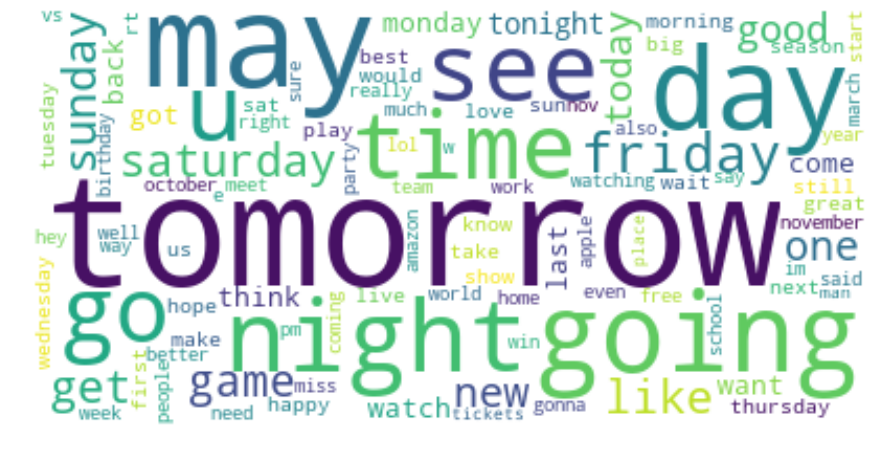

In [11]:
# Create and generate a word cloud image:
wc = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate_from_frequencies(total_counter)

plt.figure(figsize=(15,10))

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

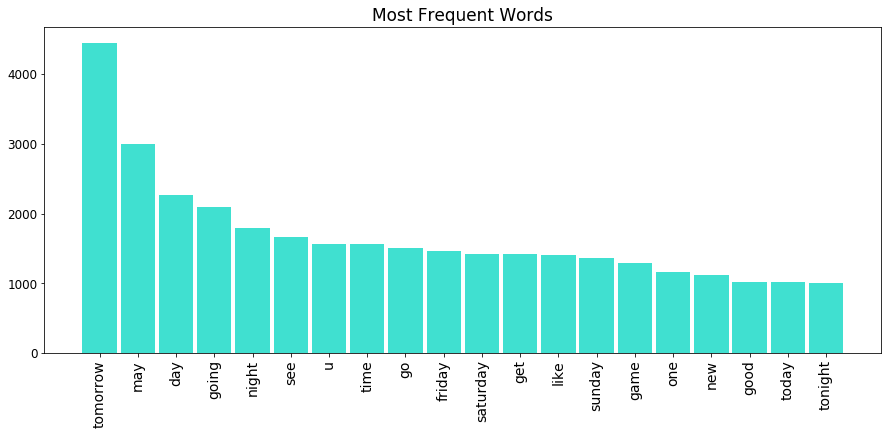

In [12]:
# Choose the names of the bars
words = list(wc.words_.keys())

# Find frequencies
freq = []
for word in words:
    freq.append(total_counter[word])
    
#np array
y_pos = np.arange(len(words[:20]))

#size
plt.figure(figsize=(15,6))
plt.title("Most Frequent Words", fontsize=17)

# Create bars
plt.bar(y_pos, freq[:20], color='turquoise', width=0.9)
 
# Create names on the x-axis
plt.xticks(y_pos, words, color='black', rotation='vertical',fontsize=14)
plt.yticks(color='black', fontsize=12)
plt.show()

<h3>Five Most Frequent Words (Sentiment Segmentation)</h3>

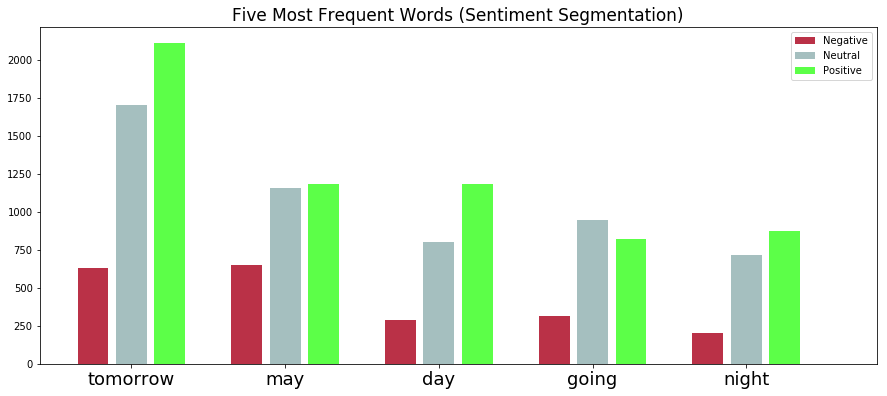

In [13]:
#FiveMostFrequent
FiveMostFrequent = list(wc.words_.keys())[:5]

# Create bars
barWidth = 0.8
bars1 = []
bars2 = []
bars3 = []
for word in FiveMostFrequent:
    bars1.append(negative_counter[word])
    bars2.append(neutral_counter[word])
    bars3.append(positive_counter[word])
    
bars4 = bars1 + bars2 + bars3
 
# The X position of bars
r1 = [1,5,9,13,17]
r2 = [2,6,10,14,18]
r3 = [3,7,11,15,19]
sep =[4,8,12,16,20]
r4 = r1 + r2 + r3 + sep

# plot size
plt.figure(figsize=(15,6))

# Create barplot
plt.bar(r1, bars1, width = barWidth, color = (0.7,0.1,0.2,0.9), label='Negative')
plt.bar(r2, bars2, width = barWidth, color = (0.3,0.5,0.5,0.5), label='Neutral')
plt.bar(r3, bars3, width = barWidth, color = (0.2,1.0,0.1,0.8), label='Positive')
plt.bar(sep, [0,0,0,0,0], width = barWidth, color = (0.0,0.0,0.0,0.0))
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend()
plt.title("Five Most Frequent Words (Sentiment Segmentation)", fontsize=17) 
# Text below each barplot with a rotation at 90°
plt.xticks([4*r + barWidth*2.5 for r in range(len(FiveMostFrequent))], FiveMostFrequent, fontsize=18)
 
# Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)
 
# Show graphic
plt.show()

<h3>Most Positive Words</h3><br>
<b>Not only measured by appearances on positive tweets </b>, but the <b>ratio between positive and negative</b> is very high<br>
Which means that they appeared exponentially more times in positive tweets rather than negative ones.<br>
That way we have a more representative result.

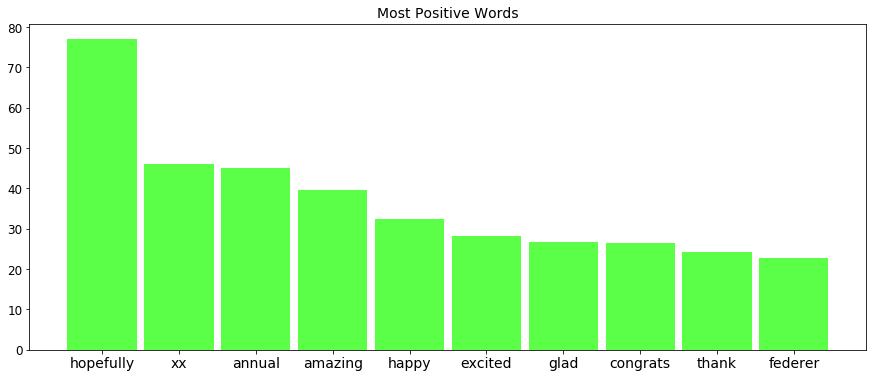

In [14]:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 50]
UsedWords.sort(key=lambda word: (positive_counter[word]/(negative_counter[word] + 1)), reverse=True)
HighRatioWords = UsedWords[:10]

# Find ratio
ratio = []
for word in HighRatioWords:
    ratio.append(positive_counter[word]/(negative_counter[word] + 1))
#np array
y_pos = np.arange(len(HighRatioWords))
#size
plt.figure(figsize=(15,6))

# Create bars
plt.bar(y_pos, ratio, color=(0.2,1.0,0.1,0.8), width=0.9)
 
# Create names on the x-axis
plt.title('Most Positive Words', fontsize=14)
plt.xticks(y_pos, HighRatioWords, color='black', fontsize=14)
plt.yticks(color='black', fontsize=12)
plt.show()

<h3>OBSERVATION !</h3>
<h4>As we see, "tomorrow" has the most appearances in positive tweets, but the ones that are used purely on positive tweets are "amazing", "happy", "excited" ... </h4>


Associated positive wordcloud

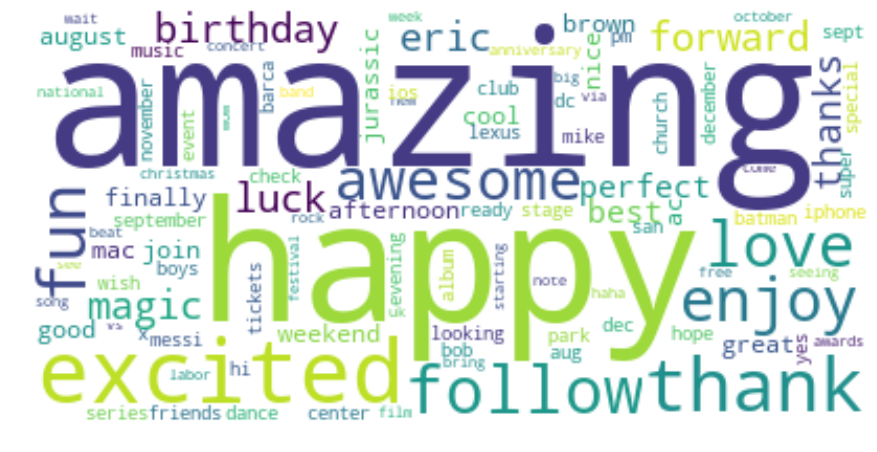

In [15]:
# Create and generate a word cloud image:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 100]
UsedWords.sort(key=lambda word: (positive_counter[word]/(negative_counter[word] + 1)), reverse=True)
HighRatioWords = UsedWords[:100]
ratio = []
for word in HighRatioWords:
    ratio.append(positive_counter[word]/(negative_counter[word] + 1))
HRWDict = dict(zip(HighRatioWords, ratio))
wc = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate_from_frequencies(HRWDict)

plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3>Most Negative Words</h3><br>
<b>Not only measured by appearances on negative tweets </b>, but the <b>ratio between positive and negative</b> is very low<br>
Which means that they appeared exponentially more times in negative tweets rather than positive ones.<br>
That way we have a more representative result.

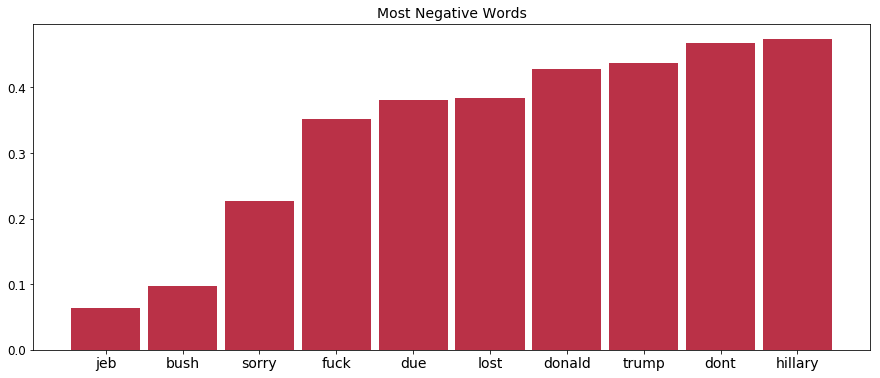

In [16]:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 100]
UsedWords.sort(key=lambda word: (positive_counter[word]/(negative_counter[word] + 1)))
LowRatioWords = UsedWords[:10]

# Find ratio
ratio = []
for word in LowRatioWords:
    ratio.append(positive_counter[word]/(negative_counter[word] + 1))
#np array
y_pos = np.arange(len(LowRatioWords))
#size
plt.figure(figsize=(15,6))

# Create bars
plt.bar(y_pos, ratio, color=(0.7,0.1,0.2,0.9), width=0.9)
 
# Create names on the x-axis
plt.title('Most Negative Words', fontsize=14)
plt.xticks(y_pos, LowRatioWords, color='black', fontsize=14)
plt.yticks(color='black', fontsize=12)
plt.show()

Associated negative wordcloud

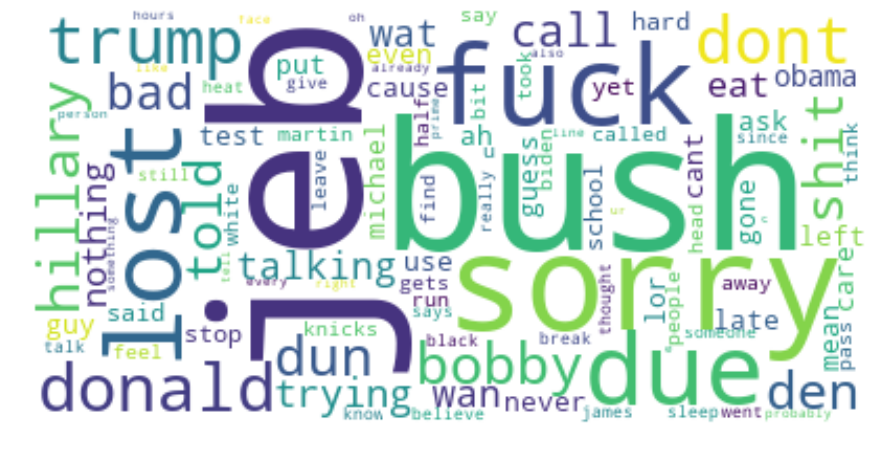

In [17]:
# Create and generate a word cloud image:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 100]
UsedWords.sort(key=lambda word: (negative_counter[word]/(positive_counter[word] + 1)), reverse=True)
LowRatioWords = UsedWords[:100]
ratio = []
for word in LowRatioWords:
    ratio.append(negative_counter[word]/(positive_counter[word] + 1))
LRWDict = dict(zip(LowRatioWords, ratio))
wc = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate_from_frequencies(LRWDict)

plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3>Most Neutral Words</h3>

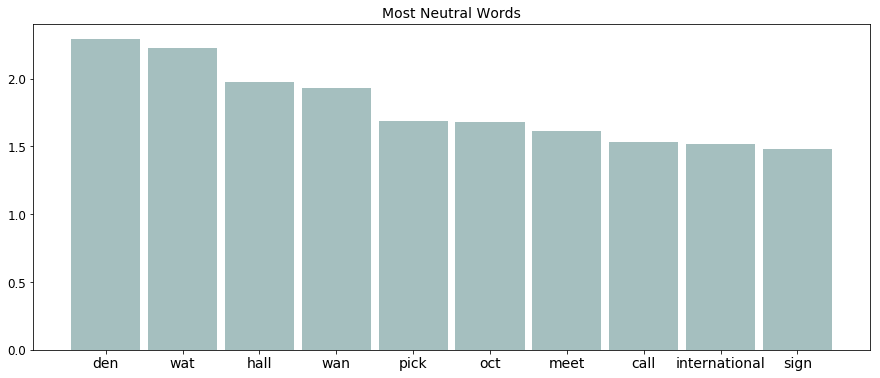

In [18]:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 100]
UsedWords.sort(key=lambda word: (neutral_counter[word]/(positive_counter[word]+negative_counter[word])), reverse=True)
HighRatioWords = UsedWords[:10]

# Find ratio
ratio = []
for word in HighRatioWords:
    ratio.append(neutral_counter[word]/(positive_counter[word]+negative_counter[word]))
#np array
y_pos = np.arange(len(HighRatioWords))
#size
plt.figure(figsize=(15,6))

# Create bars
plt.bar(y_pos, ratio, color=(0.3,0.5,0.5,0.5), width=0.9)
 
# Create names on the x-axis
plt.title('Most Neutral Words', fontsize=14)
plt.xticks(y_pos, HighRatioWords, color='black', fontsize=14)
plt.yticks(color='black', fontsize=12)
plt.show()

Associated neutral wordcloud

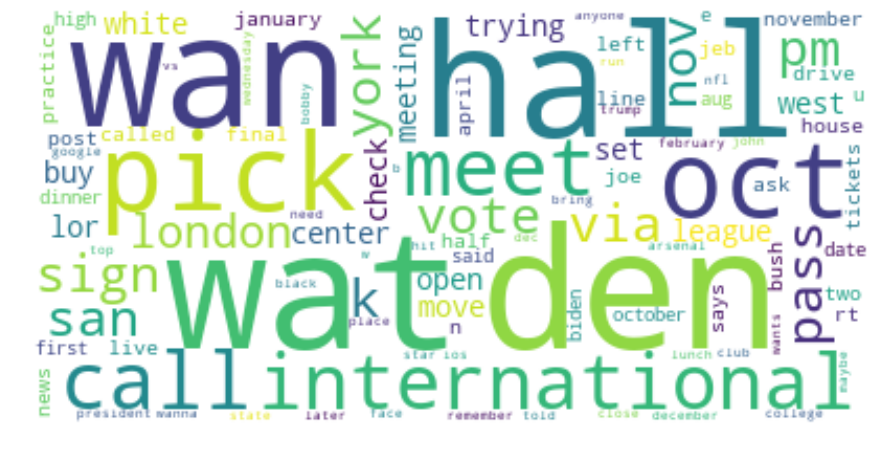

In [19]:
# Create and generate a word cloud image:
UsedWords = [word for word in total_counter.keys() if total_counter[word] >= 100]
UsedWords.sort(key=lambda word: (neutral_counter[word]/(positive_counter[word]+negative_counter[word])), reverse=True)
HighRatioWords = UsedWords[:100]
ratio = []
for word in HighRatioWords:
    ratio.append(neutral_counter[word]/(positive_counter[word]+negative_counter[word]))
HRWDict = dict(zip(HighRatioWords, ratio))
wc = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate_from_frequencies(HRWDict)

plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3>Relation between Length and Sentiment</h3><br>

In [20]:
import string 
lengths = []
for tweet in train_data.T:
    lengths.append(sum([i.strip(string.punctuation).isalpha() for i in train_data.T[tweet][1].split()]))
    
pos_lengths=[]
neg_lengths=[]
neu_lengths=[]
j=0
for i in clean_tweets[0:]: 
    if(values[j] == "positive"):
        pos_lengths.append(lengths[j])
    if(values[j] == "negative"):
        neg_lengths.append(lengths[j])
    if(values[j] == "neutral"):
        neu_lengths.append(lengths[j])
    j+=1
pos_perc=[]
neg_perc=[]
neu_perc=[]
for k in range(0,40,5):
    pos_count = 0
    neg_count = 0
    neu_count = 0
    total_count = 0
    for i in range(k,k+5):
        pos_count+=pos_lengths.count(i)
        neg_count+=neg_lengths.count(i)
        neu_count+=neu_lengths.count(i)
    total_count = pos_count + neg_count + neu_count
    if(total_count > 0):
        pos_perc.append(round(pos_count/total_count *100, 2))
        neg_perc.append(round(neg_count/total_count *100, 2))
        neu_perc.append(round(neu_count/total_count *100, 2))
    else:
        pos_perc.append(0)
        neg_perc.append(0)
        neu_perc.append(0)

<b>SAVE</b>

In [21]:
#store lengths pickle
pickle.dump(pos_perc, open('pos_perc.sav', 'wb'))
pickle.dump(neg_perc, open('neg_perc.sav', 'wb'))
pickle.dump(neu_perc, open('neu_perc.sav', 'wb'))

In [22]:
#Load the chart from my cloud account on plot.ly
IFrame(src='./tweet_lengths.html', width=950, height=500)

<br>
<h1><center>Vectorization</center></h1>
<br><h3>1. Bag Of Words</h3>

<b>Run this only if you want to do the vectorization</b><br>
Carefull you will have to store it later!!!


In [23]:
from sklearn.feature_extraction.text import CountVectorizer

#vectorization
bow_vectorizer = CountVectorizer(max_features=1000)
bow_xtrain = bow_vectorizer.fit_transform(clean_tweets_as_str)  #TWEETS : a list with the actual tweets

bow_xtest = bow_vectorizer.transform(clean_test_tweets_as_str)  #TWEETS : a list with the actual tweets

<br><h3>2. TF-IDF</h3>

<b>Run this only if you want to do the vectorization</b><br>
Carefull you will have to store it later!!!

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000, sublinear_tf=True, min_df=7) 
tfidf = tfidf_vectorizer.fit_transform(clean_tweets_as_str)

tfidf_test = tfidf_vectorizer.transform(clean_test_tweets_as_str)

<br><h3>3. Word Embeddings</h3><br></br>
Using: <br>
1. Lower Case tweets<br>
2. Tokenized tweets<br>

<b>Run this only if you want to do the vectorization</b><br>
Carefull you will have to store it later!!!

In [27]:
from gensim.models import Word2Vec

w2v_features = 300

In [28]:
%%capture
model_w2v = Word2Vec(
            size=w2v_features, # desired no. of features/independent variables
            window=5, # context window size
            min_count=1,
            sg = 1,
            hs = 0,
            negative = 10, # for negative sampling
            workers = 7) 

model_w2v.build_vocab(clean_tweets)  # prepare the model vocabulary
model_w2v.train(clean_tweets, total_examples= len(clean_tweets), epochs=10)

<b>SAVE</b><br>
Run this only if you excecuted the above cell and you want to save the vector.

In [29]:
#store bow using pickle
filename = 'word_embed_' + str(w2v_features) + '.sav'
pickle.dump(model_w2v, open(filename, 'wb'))

<b>LOAD</b><br>
Else Run this if you have already stored the word embeddings to load it instead of computing it.

In [25]:
#load stored model with 300 features
w2v_features = 300
filename = 'word_embed_300.sav'
model_w2v = pickle.load(open(filename, 'rb'))

<b>Note: </b>We could use both lowercase tweets and clean tweets for the training -> we used clean tweets in order to have a representative comparison with the other methods.<br>
Extended results and justification is given after the classification<br>

Now we trained model for epochs and it is ready.<br>
Let's play with our trained model and see some results.

In [26]:
model_w2v.wv.most_similar(positive='tomorrow')

/home/fanarosss/Programms/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dalton', 0.6936051845550537),
 ('croatia', 0.6894867420196533),
 ('drinks', 0.6872788667678833),
 ('streets', 0.6807876825332642),
 ('supposed', 0.6800881624221802),
 ('gotta', 0.6772434711456299),
 ('breakfast', 0.6723142862319946),
 ('skip', 0.6718833446502686),
 ('diet', 0.6686379909515381),
 ('fam', 0.6663280725479126)]

As we see those are the words that are seen with trump and developed a semantic relationship.

<h3>TSNE graphs</h3>
<br></br>
Function tsne_plot call for a subset of our model, our whole word2vec is quite dense to visualize it

In [27]:
from sklearn.manifold import TSNE

def tsne_plot(model, w2v):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, val in model:
        tokens.append(w2v.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15,6)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

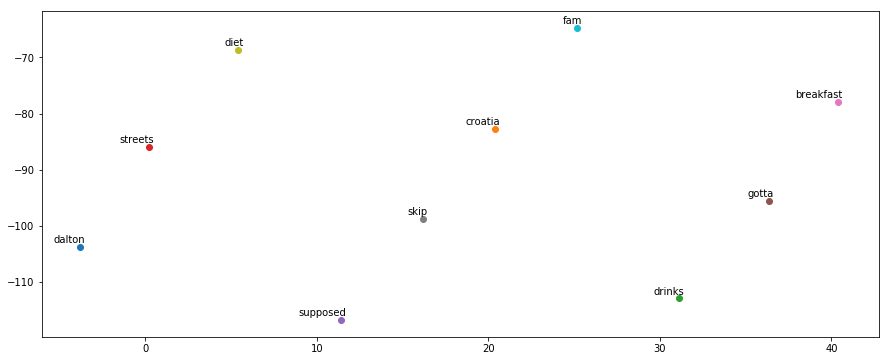

In [28]:
tsne_plot(model_w2v.wv.most_similar(positive='tomorrow'), model_w2v)

<br><br>
<center><h1>Classification</h1></center><br>
<h2>Using SVΜ classifier</h2><br>

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

<h3>1. Bag Of Words</h3>

<h4>Split the train set, and apply SVC:</h4>

In [35]:
%%capture
X_train, Y_train = bow_xtrain, train_data['Value']

X_test = bow_xtest
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [36]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred) 
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.65      0.19      0.30      3972
     neutral       0.55      0.84      0.66      5937
    positive       0.50      0.42      0.46      2375

   micro avg       0.55      0.55      0.55     12284
   macro avg       0.56      0.48      0.47     12284
weighted avg       0.57      0.55      0.50     12284



0.548925431455552

<h3>2. TFIDF</h3>

<h4>Split the train set, and apply SVC:</h4>

In [37]:
%%capture
X_train, Y_train = tfidf, train_data['Value']

X_test = tfidf_test
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [38]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred) 
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.65      0.19      0.30      3972
     neutral       0.55      0.82      0.66      5937
    positive       0.48      0.44      0.46      2375

   micro avg       0.55      0.55      0.55     12284
   macro avg       0.56      0.49      0.47     12284
weighted avg       0.57      0.55      0.50     12284



0.545262129599479

<h3>3. Word Embeddings</h3><br>
Since we can't pass the word2key vector directly in svclassifier due to multiple words with multiple features, we need to do the appropriate <u>processing</u>. <br>
With that being said, what we are going to do, is to take the <b>mean</b> of every word vector and produce a "tweet vector" with the same number of features plus whatever we judge necessary, ex. Valence.

<h4>Vector Processor: </h4>

This is the function that we use to go from word vector to tweet vector (by computing averages)<br>
Note: When a word doesn't exist in the word embeddings, we add a vector with the average of the rest words on tweet.<br>
<p>[Extra features are discussed later on the notebook]</p>

In [40]:
%%capture
extra_features = 6

def w2v_mean(model, tweets):
    w2v_train = np.zeros((len(tweets),w2v_features+extra_features), dtype="float64")
    i = 0
    for tweet in tweets:
        tweet_mean = []
        valences= [[],[],[]]
        Sx = [0,0,0]
        Sxx = [0,0,0]
        mean = [0,0,0]
        sdeviation = [0,0,0]
        n = [1,1,1]
        minv = [0,0,0]
        maxv = [0,0,0]
        for word in tweet:
            if word in model.wv.vocab:
                tweet_mean.append(model.wv[word])
            else:
                temp_array = np.zeros((w2v_features,))
                if tweet_mean:
                    temp_array = np.mean(np.array(tweet_mean), axis = 0)
                tweet_mean.append(temp_array)
            #Affin Lexica
            if word in affin_lexica.keys():
                valences[0].append(affin_lexica[word][0])
                Sx[0] += affin_lexica[word][0]
                Sxx[0] += affin_lexica[word][0]**2
                n[0] +=1
            #Tweeter Lexica
            if word in tweeter_lexica.keys():
                valences[1].append(tweeter_lexica[word][0])
                Sx[1] += tweeter_lexica[word][0]
                Sxx[1] += tweeter_lexica[word][0]**2
                n[1] +=1
            #Generic Lexica
            if word in generic_lexica.keys():
                valences[2].append(generic_lexica[word][0])
                Sx[2] += generic_lexica[word][0]
                Sxx[2] += generic_lexica[word][0]**2
                n[2] +=1 
        if tweet:
            #Compute Statistical Features
            for lex in range (0,3):
                mean[lex] = Sx[lex]/n[lex]
                sdeviation[lex] = ((Sxx[lex] - Sx[lex]**2)/n[lex])
                
            w2v_train[i] = np.append(np.mean(np.array(tweet_mean, dtype="float64"), axis = 0), 
                                     np.array([mean[0], mean[1], mean[2], 
                                               sdeviation[0], sdeviation[1], sdeviation[2]], dtype="float64"))
        else:
            w2v_train[i] = np.random.rand((w2v_features+extra_features))
        i+=1;

    return w2v_train

<b>a)  Testing the SVC on word embeddings with 300 features</b><br>

<h4>Split the train set, and apply SVC:</h4>

In [40]:
%%capture
X_train, Y_train = w2v_mean(model_w2v, clean_tweets), train_data['Value']

X_test = w2v_mean(model_w2v, clean_test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<h4>Classifier and predictions:</h4>

In [41]:
Y_pred = svclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.65      0.46      0.54      3972
     neutral       0.61      0.70      0.65      5937
    positive       0.52      0.57      0.54      2375

   micro avg       0.60      0.60      0.60     12284
   macro avg       0.59      0.58      0.58     12284
weighted avg       0.60      0.60      0.59     12284



0.5971182025398893

<b>b) Word embeddings + SVC <u>observations and conclusions</u>: </b><br><br>
As we see, with the word embeddings and SVC classifier, we achieved a percision of around 60%.<br>
To get to that percision, we tested a lot of things.<br>
<p><b>The highest accuracy</b> was achieved with input the lowercase tweets (with stop words and punctuation, emoticons).<br><br>
In the above code we use clean tweets in order <br>
1. to have an even compare with the previous algorithms<br>
2. to have a representative scaling on features<br>
<br><b>What was the main observation for the word2vec ? </b><br> 
Generally, increasing the number of features should increase the overall accuracy of the classification. This <u>isn't</u> the case here.<br><br>
<b>Due to the small dataset</b>, and the small domain size, the increase isn't dramatical (As we see in the below graph).<br>
    There is a slight increase <u>when we don't use the extra features with lexicas</u>, when we use the extra features it seems that they <b>overpower the rest vector</b> and the increase is even slighter.<br>    
<br>So there are thoughts that we have a very small dataset and the results aren't so represantative for the different vectorization methods.<br>
</p>
<br>
<b>For further more increase</b>, we expanded the feature vector to 300 + 6, where those 6 values are taken by the dictionaries.<br>
The best combination of lexicas was using the:<br> 
<ol>
    <li> affin lexica which is the more general,
    <li> the tweet lexica, specified on tweet language such as hashtags, emojis and tweet slang,
    <li> generic lexica.
</ol>
With this combination we saw a futher increase of 4-5% overall.<br><br>
We tested lot of other things that didn't work such as:<br>
<ul>
    <li>Using stemmed tweets for training and input to w2v.
    <li>Using extra features such as minimum and maximum valences.
    <li>K least positive words - K most positive words.
    <li><p>Computing the "derivative" of the function that was draw by the valence of every word in the tweet. It was a sum which was<br>  -increased when the "current_valence greater than previous_valence" and <br>  -decreased when "current_valence less than previous_valence".</p>
    <li>Applied L2 and L1 normalization.
</ul>


<h3>4. Conclusion for SVC</h3>
<br>
It is important to say that we observed a different accuracy on the validation set, than the test accuracy. <br>
Below we have a graph showing the scaling between number of features and dictionaries<br>


In [30]:
#Graph showing the Improvement between the number of features, and the extra lexica features.
IFrame(src='./w2v_scaling.html', width=950, height=600)

<p><b>Changing the training input: </b>On the other hand, when we used lowercase tweets, that had stopwords and emojis we achieved a higher accuracy - which we believe could increase even more if we increased the epochs and adjusted the hyperparameters a little.<br><br>
That is happening we believe for 2 reasons.<br><br>
1. The lexicas on emojis, punctuation, stopwords can give a more correct model<br>
2. Maybe because of our little dataset, every information can be useful.<br><br>
<b>The thing is</b>: When we used a validation set <i>(part of train set with train_test_split)</i> the accuracy was about 68% with the emojis-stopwords etc.<br>But when looking at the test dataset accuracy we understood that we were underfitting due to the very little training dataset we have.<br>
[As we will see, even with the pretrained embeddings, the difference between train accuracy and test accuracy is 10%!]<br><br>
<b>Most importantly</b> as we see in the chart below, the w2v doesn't scale at all when we use bigger feature vectors<br>
</p>

In [31]:
#Graph showing the accuracy on training w2v with stopwords, emojis and punctuation.
IFrame(src='./w2v_scaling_lowercase.html', width=950, height=600)

<br><h3>BOW vs TFIDF</h3>
As we can see from the accuracies of those two methods, the results are quite similar with BOW giving slightly better scores than TFIDF. The similarity of the results is caused by a couple of factors. First of all, the fact that punctuation and stopwords have already been removed from tweets before training and testing the data. Thus, the IDF factor of TFIDF has little work to do and maybe the words that it undermines and decreases their score (because of their frequent occurencies) are meaningful and helpful words in distinguishing sentiment. This leads to a mediocre deterioration in accuracy. Secondly, the database is relatively small with about 30.000 tweets, so the difference between the two methods cannot be seen clearly. Conclusively, these factors result in BOW being subtly more capable for analysing the given data.

<h2>Using KNN classifier</h2>

In [32]:
from sklearn.neighbors import KNeighborsClassifier

<h3>1. Bag of words</h3>

<h4>Split the train set, and apply KNN:</h4>

In [33]:
%%capture
X_train, Y_train = bow_xtrain, train_data['Value']

X_test, Y_test = bow_xtest, pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [34]:
Y_pred = knnclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.45      0.10      0.16      3972
     neutral       0.50      0.88      0.64      5937
    positive       0.40      0.18      0.25      2375

   micro avg       0.49      0.49      0.49     12284
   macro avg       0.45      0.39      0.35     12284
weighted avg       0.47      0.49      0.41     12284



0.4908010420058613

<h3>2. TFIDF</h3>

<h4>Split the train set, and apply KNN:</h4>

In [35]:
%%capture
X_train, Y_train = tfidf, train_data['Value']

X_test, Y_test = tfidf_test, pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [36]:
Y_pred = knnclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

accuracy_score(Y_test, Y_pred)

              precision    recall  f1-score   support

    negative       0.43      0.10      0.16      3972
     neutral       0.49      0.85      0.62      5937
    positive       0.38      0.20      0.26      2375

   micro avg       0.48      0.48      0.48     12284
   macro avg       0.44      0.38      0.35     12284
weighted avg       0.45      0.48      0.40     12284



0.4786714425268642

<h3>3. Word Embeddings</h3>

In [41]:
#load stored model with 300 features
w2v_features = 300
filename = 'word_embed_300.sav'
model_w2v = pickle.load(open(filename, 'rb'))

In [42]:
%%capture
X_train = w2v_mean(model_w2v, clean_tweets)
Y_train = train_data['Value']

X_test = w2v_mean(model_w2v, clean_test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

<p><b>Prediction</b></p>

In [43]:
Y_pred = knnclassifier.predict(X_test) 
Y2_pred = knnclassifier.predict(X_train)

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

print ("Accuracy for KNN:", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

    negative       0.61      0.54      0.57      3972
     neutral       0.61      0.65      0.63      5937
    positive       0.48      0.50      0.49      2375

   micro avg       0.59      0.59      0.59     12284
   macro avg       0.57      0.56      0.56     12284
weighted avg       0.59      0.59      0.58     12284

Accuracy for KNN: 0.5851514164767176


<h3>4. Conclusions about KNN:</h3><br>
KNNs accuracy is lower than SVC, and that is due to the fact that KNN is a non-parametric and lazy learning algorithm.<br>
A very important characteristic about KNN is the cursing of <b>dimensionality.</b><br>
The algorithm performs better with lesser features rather than a large amount. In order to have lot of features, you have to have a lot of data (which we do not have).
So let's see how KNN performs with a small amount of features at word embeddings.<br>

In [44]:
w2v_features = 100

#load stored model with 100 features
filename = 'word_embed_100.sav'
model_w2v = pickle.load(open(filename, 'rb'))

X_train, Y_train = w2v_mean(model_w2v, clean_tweets), train_data['Value']

X_test = w2v_mean(model_w2v, clean_test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 10,
                                    algorithm='auto',
                                    metric='minkowski',
                                    p=2,
                                    n_jobs=-1)
knnclassifier.fit(X_train, Y_train)

Y_pred = knnclassifier.predict(X_test) 

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

print ("Accuracy for 100 features:", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

    negative       0.62      0.55      0.58      3972
     neutral       0.62      0.65      0.63      5937
    positive       0.48      0.51      0.49      2375

   micro avg       0.59      0.59      0.59     12284
   macro avg       0.57      0.57      0.57     12284
weighted avg       0.59      0.59      0.59     12284

Accuracy for 100 features: 0.5902800390752198


As we can see the accuracy not only it didn't get lower, but it also grew. This is expected for KNN due to the problem for high dimensionality<br>
Consider that with SVM there was a slight difference between those two<br>
<b>That means, that maybe above 200-300 features KNN will start overfitting with the data that we have.</b><br>

<br><h2>Round Robin Classification</h2>

<b>1) </b> Separating the tweets into 3 datasets (same number as our classifiers).<br>

In [45]:
pos_neg_tweets = []
pos_neu_tweets = []
neg_neu_tweets = []
pos_neg_values = []
neg_neu_values = []
pos_neu_values = []

#for word2vec tweets
i = 0
for tweet in clean_tweets:
    if (train_data['Value'][i] == "positive"):
        pos_neg_tweets.append(tweet)
        pos_neu_tweets.append(tweet)
        pos_neg_values.append("positive")
        pos_neu_values.append("positive")
    elif (train_data['Value'][i] == "negative"):
        pos_neg_tweets.append(tweet)
        neg_neu_tweets.append(tweet)
        pos_neg_values.append("negative")
        neg_neu_values.append("negative")
    elif (train_data['Value'][i] == "neutral"):
        pos_neu_tweets.append(tweet)
        neg_neu_tweets.append(tweet)
        pos_neu_values.append("neutral")
        neg_neu_values.append("neutral")
    i += 1

<b>2)</b> Loading embeddings

In [46]:
#load stored model with 300 features
w2v_features = 300
filename = 'word_embed_300.sav'
model_w2v = pickle.load(open(filename, 'rb'))

<b>3)</b> Creating the 3 required classifiers

<b>Positive Negative classifier</b>

In [47]:
X1_train = w2v_mean(model_w2v, pos_neg_tweets)
Y1_train = pos_neg_values

X1_test = w2v_mean(model_w2v, clean_tweets)
Y1_test = train_data['Value']

X1_test2 = w2v_mean(model_w2v, clean_test_tweets)
Y1_test2 = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 50,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X1_train, Y1_train)

Y1_pred = knnclassifier.predict_proba(X1_test) 
Y1_pred2 = knnclassifier.predict_proba(X1_test2)

<b>Positive Neutral Classifier</b>

In [48]:
X2_train = w2v_mean(model_w2v, pos_neu_tweets)
Y2_train = pos_neu_values

X2_test = w2v_mean(model_w2v, clean_tweets)
Y2_test = train_data['Value']

X2_test2 = w2v_mean(model_w2v, clean_test_tweets)
Y2_test2 = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 50,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X2_train, Y2_train)

Y2_pred = knnclassifier.predict_proba(X2_test) 
Y2_pred2 = knnclassifier.predict_proba(X2_test2) 

<b>Negative Neutral Classifier</b>

In [49]:
X3_train = w2v_mean(model_w2v, neg_neu_tweets)
Y3_train = neg_neu_values

X3_test = w2v_mean(model_w2v, clean_tweets)
Y3_test = train_data['Value']

X3_test2 = w2v_mean(model_w2v, clean_test_tweets)
Y3_test2 = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 50,
                                    algorithm='auto',
                                    metric='minkowski',
                                    n_jobs=-1)
knnclassifier.fit(X3_train, Y3_train)

Y3_pred = knnclassifier.predict_proba(X3_test) 
Y3_pred2 = knnclassifier.predict_proba(X3_test2) 

<h4>4) Final classifying</h4><br>
We feed into the final KNN classifier the N,6 size feature vector. <br>
2 values from each classifier are produced - posterior probability.<br>
So we take and feed these probabilities into this final classifier. <br><b> 
Train data probabilities are used now for fitting the classifier, and the test probabilities to classify them</b><br>

In [50]:
X4_train = np.vstack((np.array(Y1_pred).T, np.array(Y2_pred).T, np.array(Y3_pred).T)).T
Y4_train = train_data['Value']

X4_test = np.vstack((np.array(Y1_pred2).T, np.array(Y2_pred2).T, np.array(Y3_pred2).T)).T
Y4_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

knnclassifier = KNeighborsClassifier(n_neighbors = 50,
                                    algorithm='auto',
                                    metric='minkowski',
                                    leaf_size=5,
                                    n_jobs=-1)

knnclassifier.fit(X4_train, Y4_train)

Y4_pred = knnclassifier.predict(X4_test) 

confusion_matrix(Y4_test,Y4_pred)  
print (classification_report(Y4_test,Y4_pred))

print ("Round Robin accuracy score:", accuracy_score(Y4_test, Y4_pred))

              precision    recall  f1-score   support

    negative       0.65      0.51      0.57      3972
     neutral       0.62      0.68      0.65      5937
    positive       0.48      0.55      0.51      2375

   micro avg       0.60      0.60      0.60     12284
   macro avg       0.58      0.58      0.58     12284
weighted avg       0.60      0.60      0.60     12284

Round Robin accuracy score: 0.597525236079453


<br><h2>SVM vs KNN vs RR</h2><br>

In [51]:
# Graph comparing the different classifiers and methods
IFrame(src='./cl_comparisons.html', width=950, height=550)

<br><h3>EXTRA observations with pretrained embeddings</h3>
<br><b>Finally,</b> let's use the pretrained embeddings and see how they do, in comparison with our implementation.<br>
Choose <b>one</b> of the following dataset to load<br>

In [52]:
w2v_features = 300
embeddings_dict = {}

f = open('datastories.twitter.300d.txt', "r", encoding="utf-8")

for i, line in enumerate(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs

In [53]:
w2v_features = 100
embeddings_dict = {}

f = open('datastories.twitter.100d.txt', "r", encoding="utf-8")

for i, line in enumerate(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs

Special function made to adjust the w2v without lexicas, to see how the pretrained embeddings behave.

In [54]:
extra_features = 6

def w2v_avg(model, tweets):
    w2v_train = np.zeros((len(tweets),w2v_features+extra_features))
    i = 0
    for tweet in tweets:
        tweet_mean = []
        valences= [[],[],[]]
        Sx = [0,0,0]
        Sxx = [0,0,0]
        mean = [0,0,0]
        sdeviation = [0,0,0]
        n = [1,1,1]
        minv = [0,0,0]
        maxv = [0,0,0]
        for word in tweet:
            if word in model:
                tweet_mean.append(model[word])
            else:
                temp_array = np.zeros((w2v_features,))
                if tweet_mean:
                    temp_array = np.mean(np.array(tweet_mean), axis = 0)
                tweet_mean.append(temp_array)
            #Affin Lexica
            if word in affin_lexica.keys():
                valences[0].append(affin_lexica[word][0])
                Sx[0] += affin_lexica[word][0]
                Sxx[0] += affin_lexica[word][0]**2
                n[0] +=1
            #Tweeter Lexica
            if word in tweeter_lexica.keys():
                valences[1].append(tweeter_lexica[word][0])
                Sx[1] += tweeter_lexica[word][0]
                Sxx[1] += tweeter_lexica[word][0]**2
                n[1] +=1
            #Generic Lexica
            if word in generic_lexica.keys():
                valences[2].append(generic_lexica[word][0])
                Sx[2] += generic_lexica[word][0]
                Sxx[2] += generic_lexica[word][0]**2
                n[2] +=1 
        if tweet:
            #Compute Statistical Features
            for lex in range (0,3):
                mean[lex] = Sx[lex]/n[lex]
                sdeviation[lex] = ((Sxx[lex] - Sx[lex]**2)/n[lex])
                
            w2v_train[i] = np.append(np.mean(np.array(tweet_mean), axis = 0), 
                                     np.array([mean[0], mean[1], mean[2], 
                                               sdeviation[0], sdeviation[1], sdeviation[2]]))
        else:
            w2v_train[i] = np.random.randn((w2v_features+extra_features))
        i+=1;

    return w2v_train

Classsify with <b>SVM</b>:

In [55]:
%%capture
X_train, Y_train = w2v_avg(embeddings_dict, clean_tweets), train_data['Value']

X_test = w2v_avg(embeddings_dict, clean_test_tweets)
Y_test = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", sep='\t', names=['Value'], usecols = [1])

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

<b>Predictions:</b>

In [56]:
Y_pred = svclassifier.predict(X_test) 
Y2_pred = svclassifier.predict(X_train)

confusion_matrix(Y_test,Y_pred)  
print(classification_report(Y_test,Y_pred))

print ("Accuracy with the pretrained embeddings: ", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

    negative       0.64      0.60      0.62      3972
     neutral       0.65      0.64      0.64      5937
    positive       0.53      0.62      0.57      2375

   micro avg       0.62      0.62      0.62     12284
   macro avg       0.61      0.62      0.61     12284
weighted avg       0.62      0.62      0.62     12284

Accuracy with the pretrained embeddings:  0.6195050472158906


As it is obvious, the results with the pretrained embeddings are slightly better.<br>
<b>Still</b> there is no drastical optimization as the number of features increases.